In [1]:
!pip install pycocotools


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 6.8 MB/s eta 0:00:00


In [2]:
from pycocotools.coco import COCO
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import sys
import wandb
sys.path.append('/kaggle/usr/lib/wandblogin/')
from wandblogin import login
login()


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
coco = COCO('/kaggle/input/fracatlas-original-dataset/FracAtlas/Annotations/COCO JSON/COCO_fracture_masks.json')
img_dir = '/kaggle/input/fracatlas-original-dataset/FracAtlas/images/Fractured'
image_id = 12

img = coco.imgs[image_id]


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


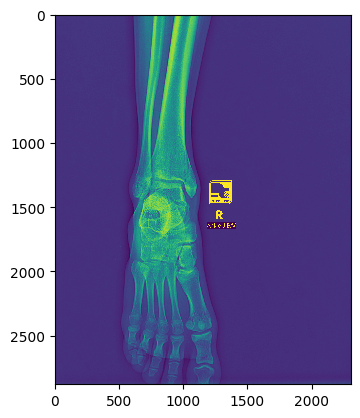

In [4]:
image = np.array(Image.open(os.path.join(img_dir, img['file_name'])))
plt.imshow(image, interpolation='nearest')
plt.show()


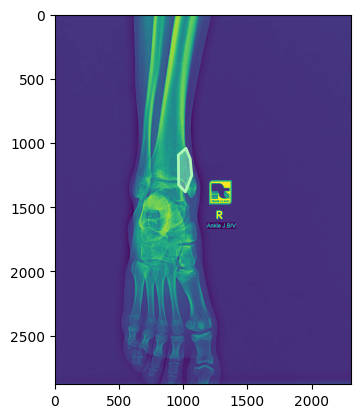

In [5]:
plt.imshow(image)
cat_ids = coco.getCatIds()
anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = coco.loadAnns(anns_ids)
coco.showAnns(anns)

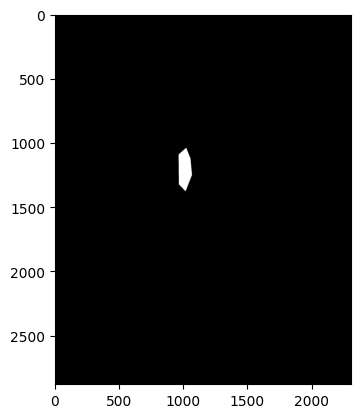

In [6]:
mask = coco.annToMask(anns[0])
for i in range(len(anns)):
    mask += coco.annToMask(anns[i])

plt.imshow(mask,cmap='gray')

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


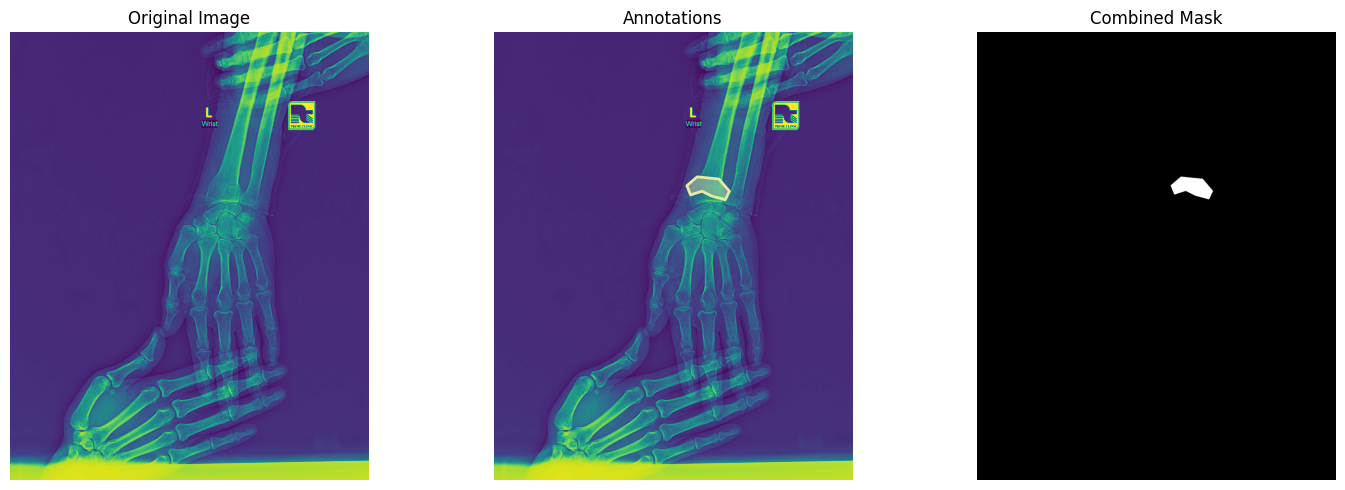

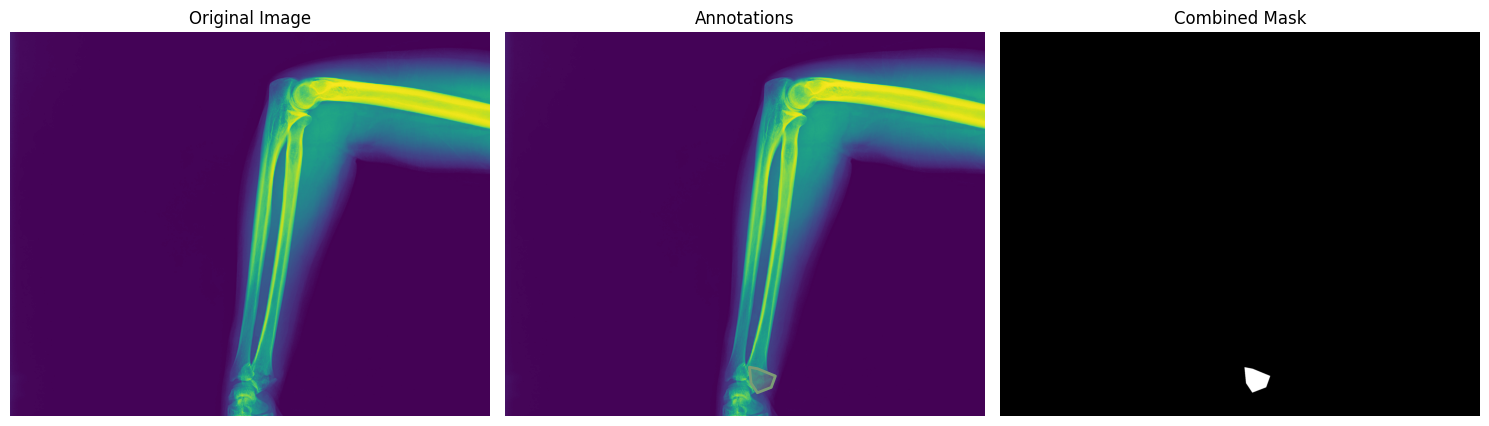

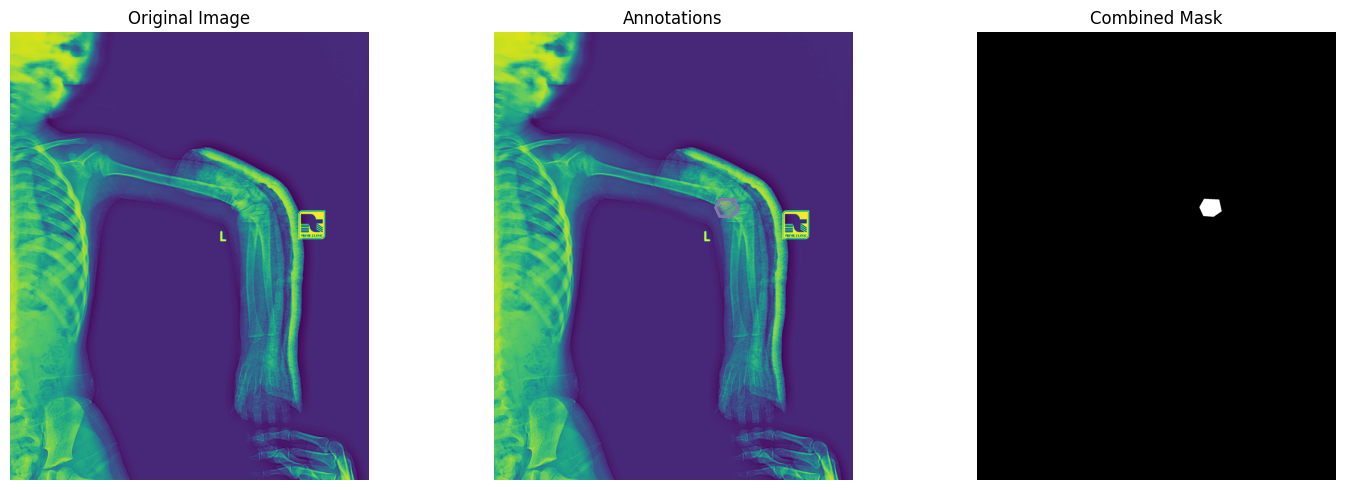

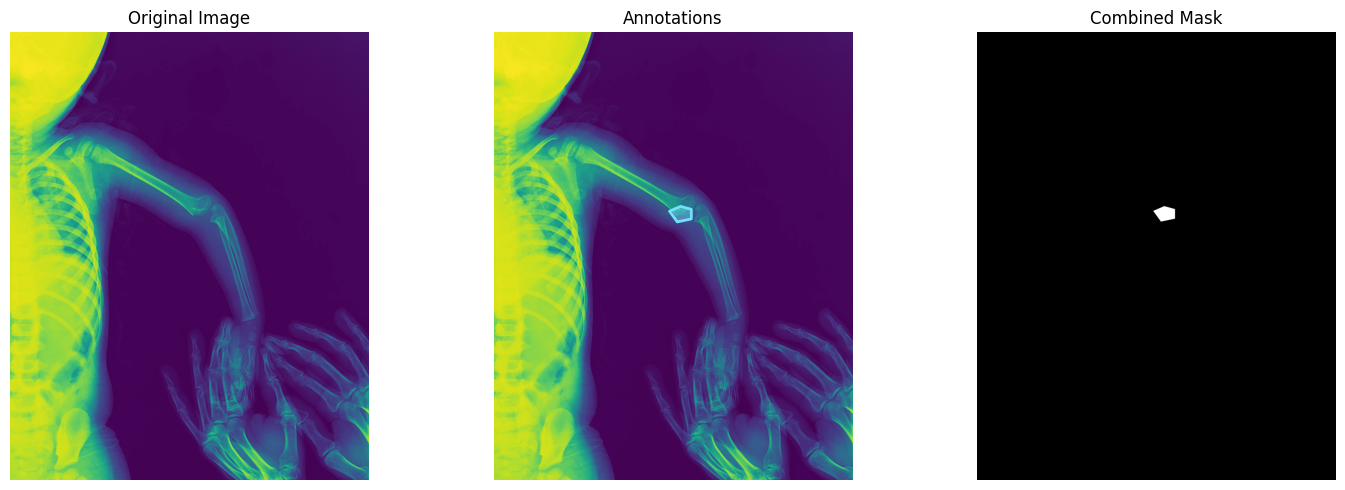

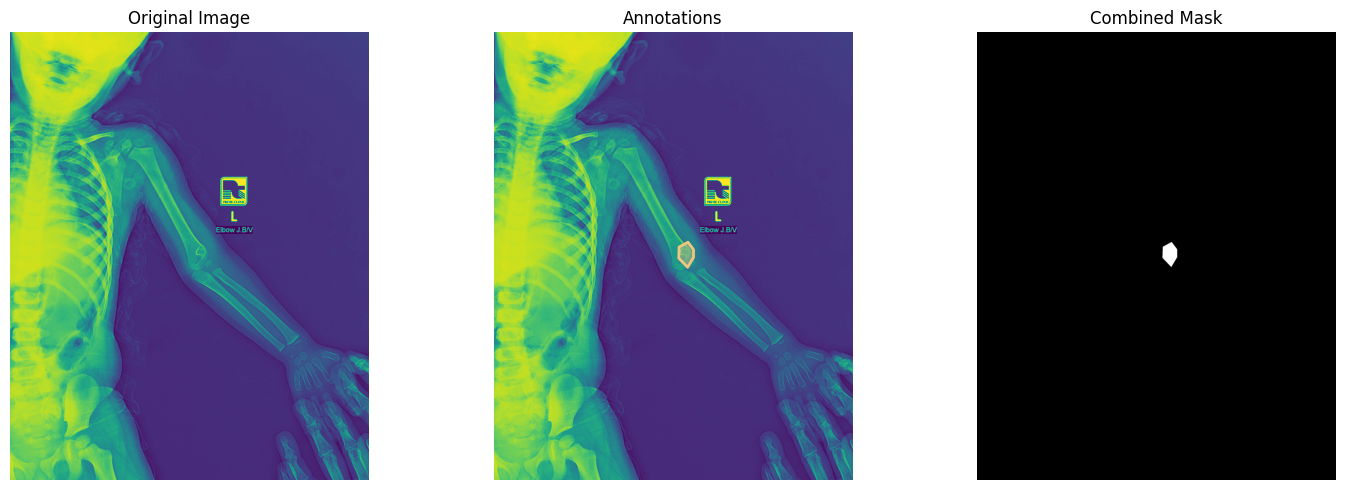

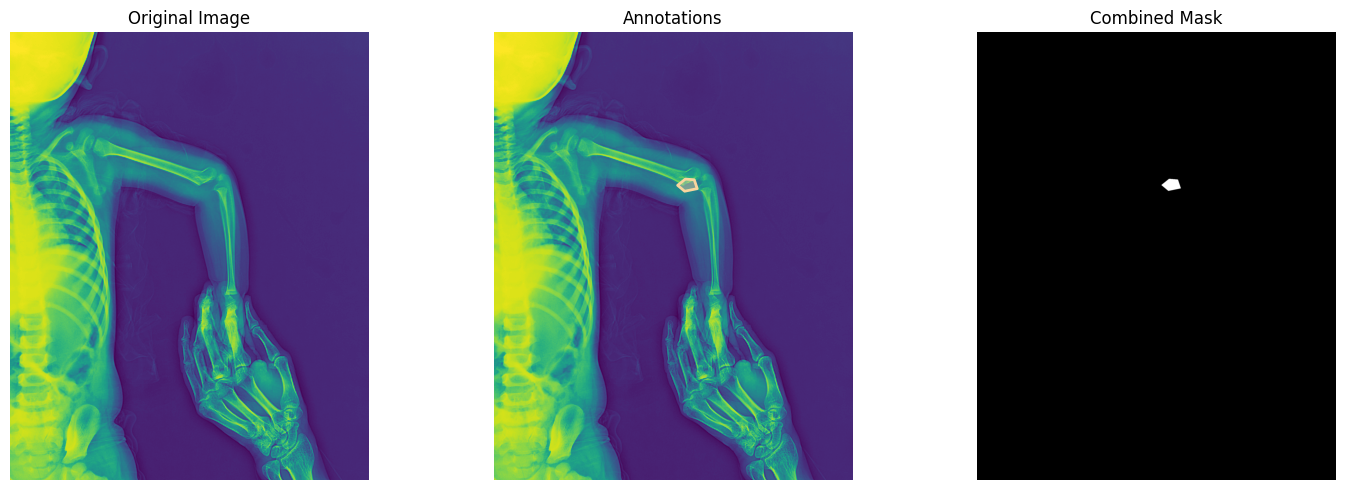

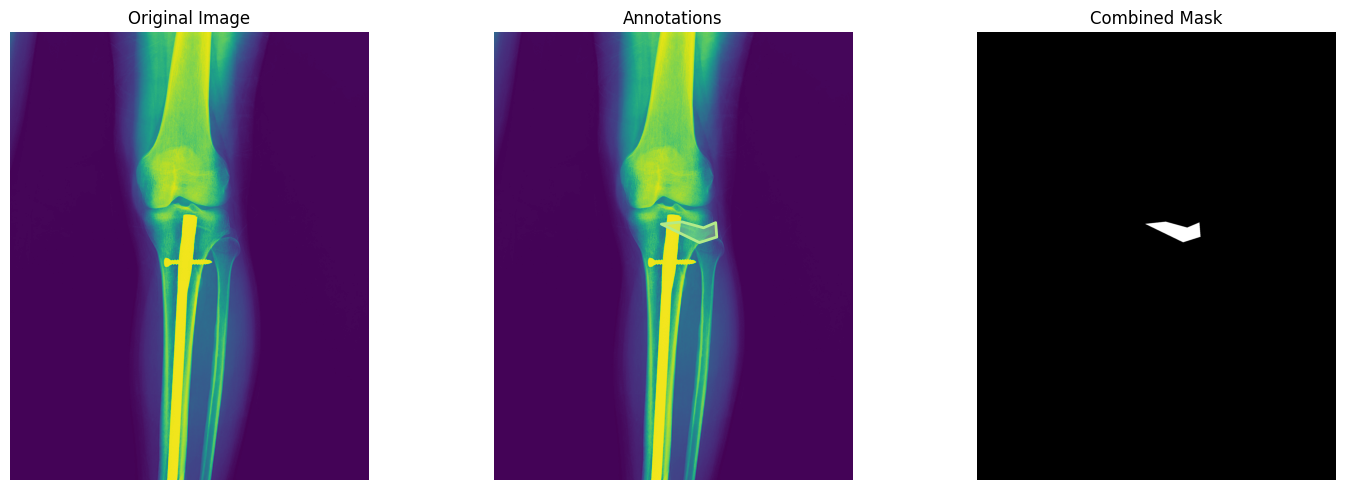

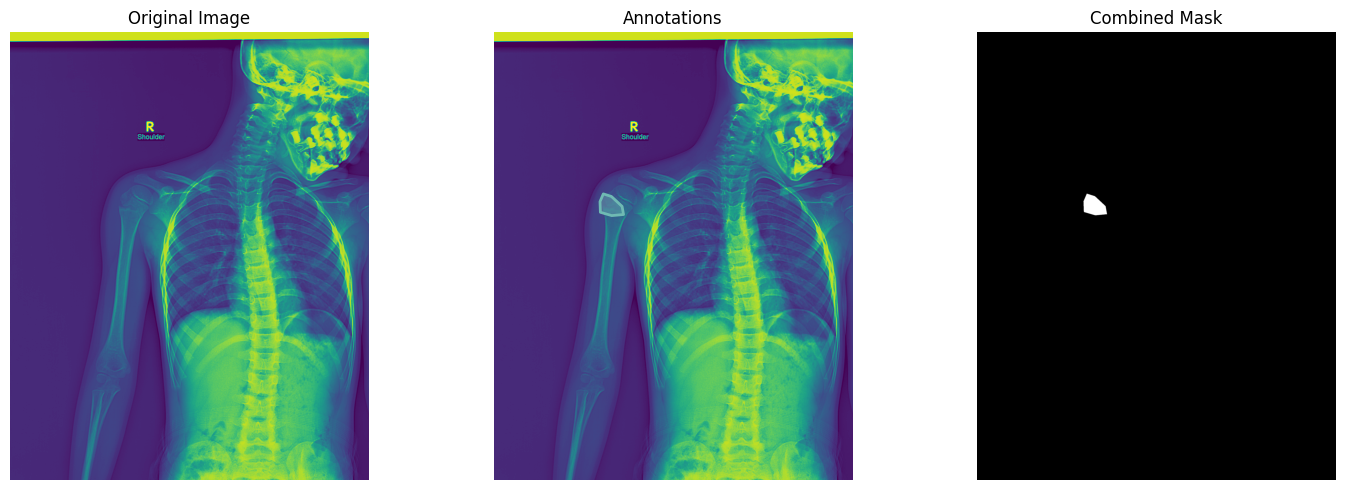

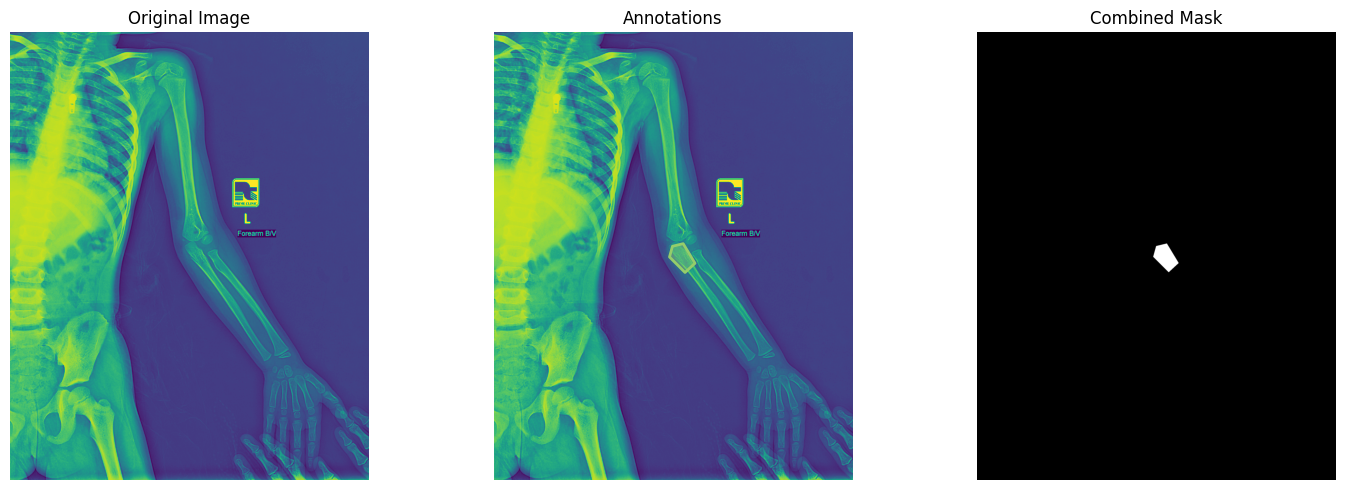

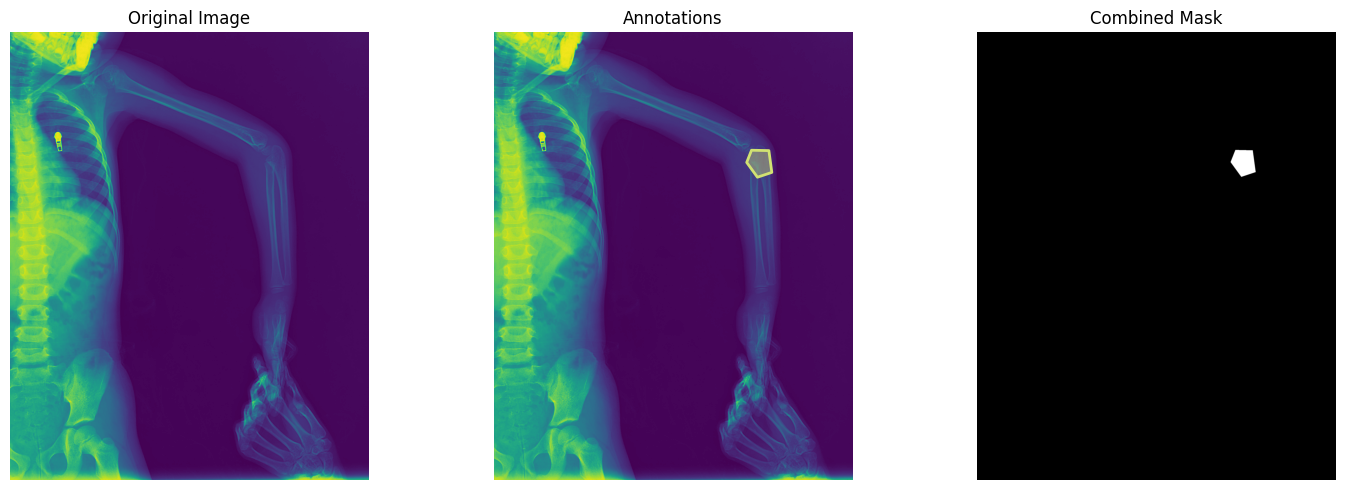

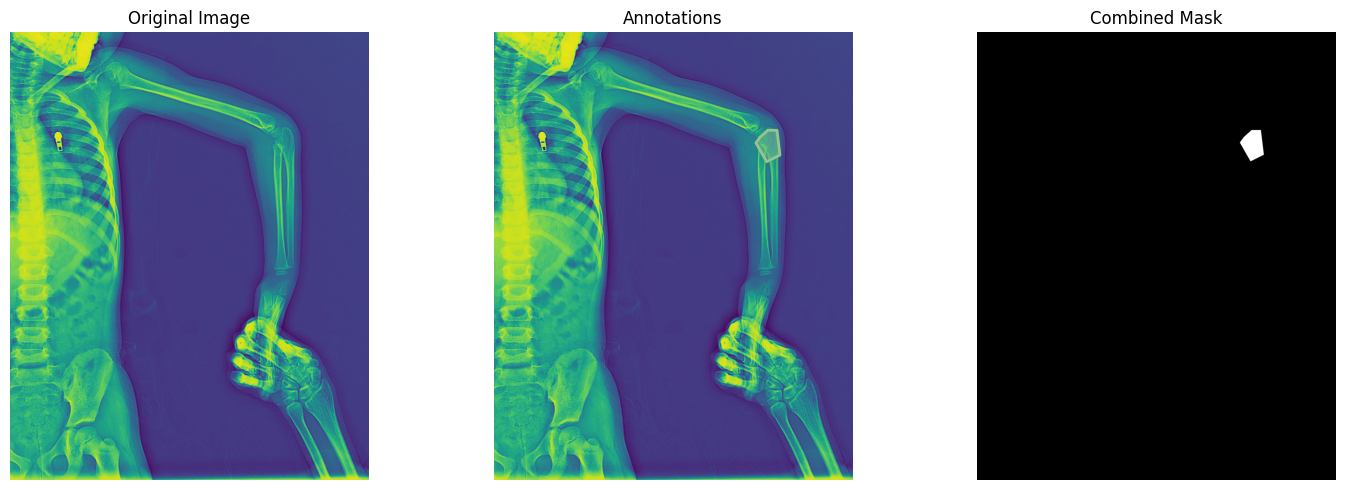

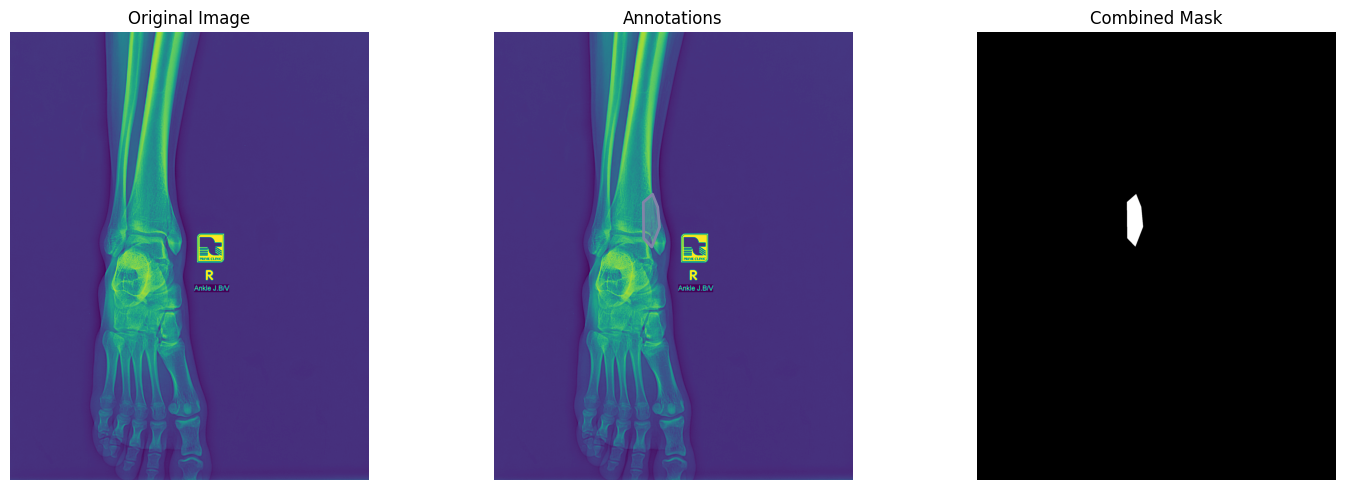

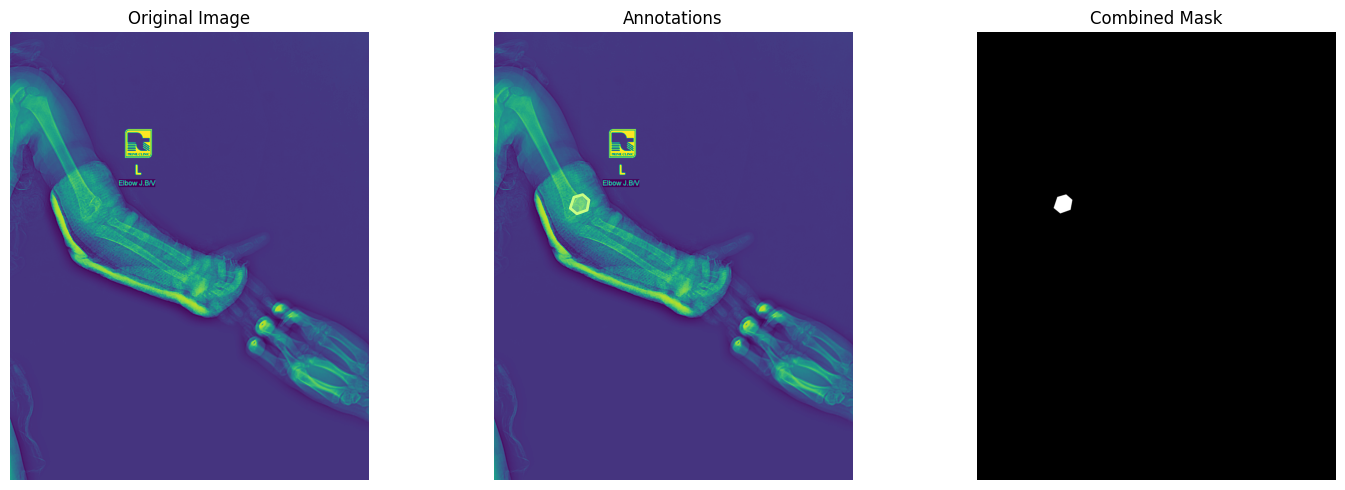

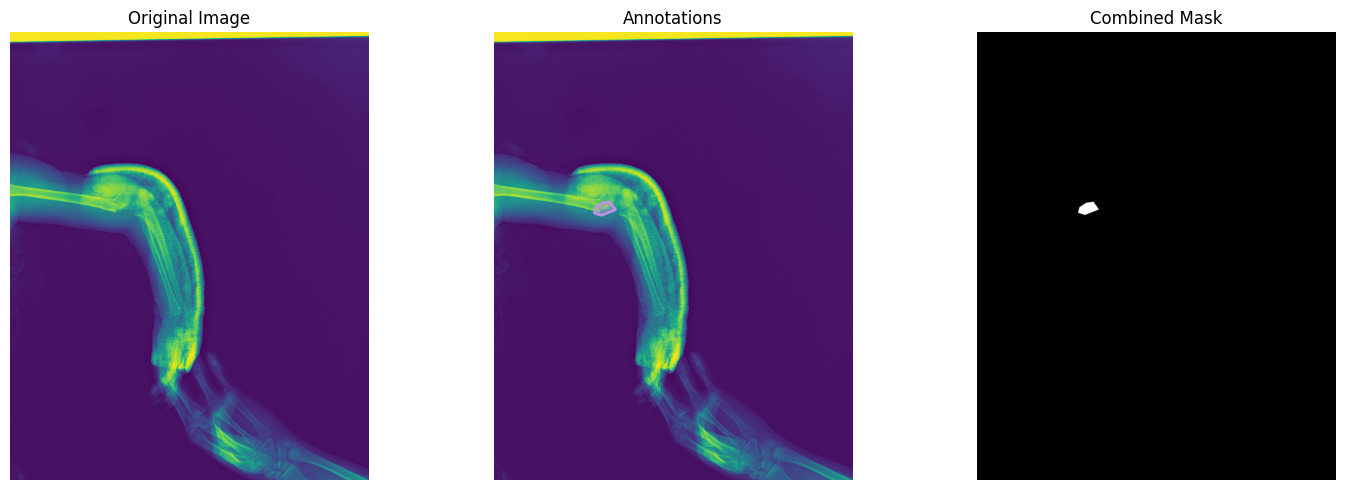

In [7]:
from pycocotools.coco import COCO
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
coco = COCO('/kaggle/input/fracatlas-original-dataset/FracAtlas/Annotations/COCO JSON/COCO_fracture_masks.json')

img_dir = '/kaggle/input/fracatlas-original-dataset/FracAtlas/images/Fractured'
output_dir = '/kaggle/working/fracatlas/images/fractured_masks/'

os.makedirs(output_dir, exist_ok=True)

image_ids = coco.getImgIds()
num_images =14
for i in range(num_images):    
    img = coco.loadImgs(image_ids[i])[0]
    image = np.array(Image.open(os.path.join(img_dir, img['file_name'])))

    

    cat_ids = coco.getCatIds()
    anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
    anns = coco.loadAnns(anns_ids)

    mask = coco.annToMask(anns[0])
    for j in range(1, len(anns)):
        mask += coco.annToMask(anns[j])
        
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Original Image')
    
    
    plt.subplot(1, 3, 2)
    plt.imshow(image)
    coco.showAnns(anns)
    plt.axis('off')
    plt.title('Annotations')

    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title('Combined Mask')
    
    plt.tight_layout()
    plt.show()


In [8]:
import os
import random
import shutil
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
# import wandb

# # Initialize wandb
wandb.init(project="fracatlas-fracture-detection")

image_folder_fractured = '/kaggle/input/fractlas-segmentation-or-classification/images/Fractured'
image_folder_non_fractured = '/kaggle/input/fractlas-segmentation-or-classification/images/non_fractured'
train_folder = '/kaggle/working/train'
val_folder = '/kaggle/working/val'
test_folder = '/kaggle/working/test'

os.makedirs(train_folder + '/fractured', exist_ok=True)
os.makedirs(train_folder + '/non_fractured', exist_ok=True)
os.makedirs(val_folder + '/fractured', exist_ok=True)
os.makedirs(val_folder + '/non_fractured', exist_ok=True)
os.makedirs(test_folder + '/fractured', exist_ok=True)
os.makedirs(test_folder + '/non_fractured', exist_ok=True)

def split_images(image_folder, train_folder, val_folder, test_folder, split_ratio=(0.8, 0.1, 0.1)):
    image_files = os.listdir(image_folder)
    random.shuffle(image_files)
    num_images = len(image_files)
    num_train = int(split_ratio[0] * num_images)
    num_val = int(split_ratio[1] * num_images)

    train_files = image_files[:num_train]
    val_files = image_files[num_train:num_train + num_val]
    test_files = image_files[num_train + num_val:]

    for file in train_files:
        shutil.copy(os.path.join(image_folder, file), os.path.join(train_folder, file))
    for file in val_files:
        shutil.copy(os.path.join(image_folder, file), os.path.join(val_folder, file))
    for file in test_files:
        shutil.copy(os.path.join(image_folder, file), os.path.join(test_folder, file))

split_images(image_folder_fractured, train_folder + '/fractured', val_folder + '/fractured', test_folder + '/fractured')
split_images(image_folder_non_fractured, train_folder + '/non_fractured', val_folder + '/non_fractured', test_folder + '/non_fractured')

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_folder, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=150, shuffle=True)

val_dataset = torchvision.datasets.ImageFolder(val_folder, transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = torchvision.datasets.ImageFolder(test_folder, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_val_acc = 0.0

# Log initial configuration
wandb.config = {
    "learning_rate": 0.001,
    "epochs": 25,
    "batch_size": 150
}

num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'), 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Log training metrics
    wandb.log({"epoch": epoch+1, "train_loss": running_loss/len(train_loader)})

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # Log validation images
            if i == 0:
                wandb.log({"examples": [wandb.Image(img) for img in images.cpu()]})

    val_acc = correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Validation Accuracy: {val_acc*100:.2f}%')

    # Log validation accuracy
    wandb.log({"val_accuracy": val_acc})

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        print("saving...")
        torch.save(model.state_dict(), '/kaggle/working/best_model.pth')

print('Finished Training')

model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

# Log final test accuracy
wandb.log({"test_accuracy": test_accuracy})


wandb: Currently logged in as: shyamdgupta (shyam-d-gupta). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240611_123948-0bbbd0yl
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run glad-totem-3
wandb: ⭐️ View project at https://wandb.ai/shyam-d-gupta/fracatlas-fracture-detection
wandb: 🚀 View run at https://wandb.ai/shyam-d-gupta/fracatlas-fracture-detection/runs/0bbbd0yl
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and 

Epoch 1/25, Loss: 0.4790, Validation Accuracy: 19.95%
saving...


Epoch 2/25: 100%|██████████| 22/22 [00:51<00:00,  2.32s/it]


Epoch 2/25, Loss: 0.3601, Validation Accuracy: 85.04%
saving...


Epoch 3/25: 100%|██████████| 22/22 [00:50<00:00,  2.31s/it]


Epoch 3/25, Loss: 0.3116, Validation Accuracy: 85.54%
saving...


Epoch 4/25: 100%|██████████| 22/22 [00:50<00:00,  2.30s/it]


Epoch 4/25, Loss: 0.2755, Validation Accuracy: 86.28%
saving...


Epoch 5/25: 100%|██████████| 22/22 [00:50<00:00,  2.32s/it]


Epoch 5/25, Loss: 0.2594, Validation Accuracy: 83.29%


Epoch 6/25: 100%|██████████| 22/22 [00:50<00:00,  2.31s/it]


Epoch 6/25, Loss: 0.2250, Validation Accuracy: 84.54%


Epoch 7/25: 100%|██████████| 22/22 [00:50<00:00,  2.31s/it]


Epoch 7/25, Loss: 0.2010, Validation Accuracy: 86.53%
saving...


Epoch 8/25: 100%|██████████| 22/22 [00:51<00:00,  2.32s/it]


Epoch 8/25, Loss: 0.1679, Validation Accuracy: 76.31%


Epoch 9/25: 100%|██████████| 22/22 [00:51<00:00,  2.32s/it]


Epoch 9/25, Loss: 0.1799, Validation Accuracy: 85.79%


Epoch 10/25: 100%|██████████| 22/22 [00:50<00:00,  2.32s/it]


Epoch 10/25, Loss: 0.1362, Validation Accuracy: 73.57%


Epoch 11/25: 100%|██████████| 22/22 [00:51<00:00,  2.33s/it]


Epoch 11/25, Loss: 0.0963, Validation Accuracy: 83.04%


Epoch 12/25: 100%|██████████| 22/22 [00:51<00:00,  2.34s/it]


Epoch 12/25, Loss: 0.1524, Validation Accuracy: 83.79%


Epoch 13/25: 100%|██████████| 22/22 [00:51<00:00,  2.34s/it]


Epoch 13/25, Loss: 0.0937, Validation Accuracy: 88.03%
saving...


Epoch 14/25: 100%|██████████| 22/22 [00:51<00:00,  2.33s/it]


Epoch 14/25, Loss: 0.0732, Validation Accuracy: 86.03%


Epoch 15/25: 100%|██████████| 22/22 [00:51<00:00,  2.33s/it]


Epoch 15/25, Loss: 0.0584, Validation Accuracy: 86.78%


Epoch 16/25: 100%|██████████| 22/22 [00:51<00:00,  2.33s/it]


Epoch 16/25, Loss: 0.0469, Validation Accuracy: 84.04%


Epoch 17/25: 100%|██████████| 22/22 [00:51<00:00,  2.33s/it]


Epoch 17/25, Loss: 0.0478, Validation Accuracy: 86.03%


Epoch 18/25: 100%|██████████| 22/22 [00:51<00:00,  2.34s/it]


Epoch 18/25, Loss: 0.0444, Validation Accuracy: 87.03%


Epoch 19/25: 100%|██████████| 22/22 [00:51<00:00,  2.34s/it]


Epoch 19/25, Loss: 0.0284, Validation Accuracy: 86.03%


Epoch 20/25: 100%|██████████| 22/22 [00:51<00:00,  2.33s/it]


Epoch 20/25, Loss: 0.0254, Validation Accuracy: 84.54%


Epoch 21/25: 100%|██████████| 22/22 [00:51<00:00,  2.33s/it]


Epoch 21/25, Loss: 0.0352, Validation Accuracy: 84.79%


Epoch 22/25: 100%|██████████| 22/22 [00:51<00:00,  2.33s/it]


Epoch 22/25, Loss: 0.0356, Validation Accuracy: 84.29%


Epoch 23/25: 100%|██████████| 22/22 [00:51<00:00,  2.35s/it]


Epoch 23/25, Loss: 0.0214, Validation Accuracy: 87.03%


Epoch 24/25: 100%|██████████| 22/22 [00:52<00:00,  2.40s/it]


Epoch 24/25, Loss: 0.0287, Validation Accuracy: 84.79%


Epoch 25/25: 100%|██████████| 22/22 [00:52<00:00,  2.38s/it]


Epoch 25/25, Loss: 0.0399, Validation Accuracy: 83.79%
Finished Training
Test Accuracy: 87.41%
